In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial as scs
import scipy.integrate
from scipy.interpolate import CubicSpline
import scipy.spatial.transform as sst
import functools

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
class CUBE(object):
  def __init__(self, fname):
    f = open(fname, 'r')
    for i in range(2): f.readline() # echo comment
    tkns = f.readline().split() # number of atoms included in the file followed by the position of the origin of the volumetric data
    self.natoms = int(tkns[0])
    self.origin = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    tkns = f.readline().split() #
    self.NX = int(tkns[0])
    self.X = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    tkns = f.readline().split() #
    self.NY = int(tkns[0])
    self.Y = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    tkns = f.readline().split() #
    self.NZ = int(tkns[0])
    self.Z = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    self.atoms = []
    for i in range(self.natoms):
      tkns = f.readline().split()
      self.atoms.append([tkns[0], tkns[2], tkns[3], tkns[4]])
    self.data = np.zeros((self.NX,self.NY,self.NZ))
    i=0
    for s in f:
      for v in s.split():
        self.data[i//(self.NY*self.NZ), (i//self.NZ)%self.NY, i%self.NZ] = float(v)
        i+=1
    if i != self.NX*self.NY*self.NZ: raise NameError("FSCK!")


In [164]:
@functools.lru_cache(32)
def read_qs(folder):
    cube = CUBE('%s/DENSITY.cube' % folder)
    return cube
    #cube = CUBE('data/CO-2/box-12/%s/DENSITY.cube' % folder)
    return cube.data

In [168]:
def get_deriv(basedir, loc, site):
    if loc != '1.0':
        up = read_qs('%s/lval-%s00000-%s-up' %(basedir, loc, site))
    else:
        up = read_qs('%s/lval-1.000000' % basedir)
    if loc != '0.0':
        dn = read_qs('%s/lval-%s00000-%s-dn'% (basedir, loc, site))
    else:
        dn = read_qs('%s/lval-0.000000' % basedir)
    if loc in '0.0 1.0'.split():
        delta = 0.005
    else:
        delta = 0.01
    return (up.data-dn.data)/delta    

def get_total(site):
    lvals = []
    ds = []
    for mval in '0.0 0.2 0.4 0.6 0.8 1.0'.split():
        tmp = get_deriv(mval, site)
        #plt.plot(tmp.sum(axis=1).sum(axis=1))
        #plt.axvline(81)
        #plt.axvline(99)
        #plt.show()
        ds.append(tmp.ravel())
        lvals.append(float(mval))
    #total = scipy.integrate.simps(ds, lvals, axis=0)
    total = np.trapz(ds, lvals, axis=0)
    return total.reshape(tmp.shape)

tr = read_qs('lval-0.000000')
tf = read_qs('lval-1.000000')
#plt.plot(tr.sum(axis=1).sum(axis=1))
tc= get_total('C')
#plt.plot(tc.sum(axis=1).sum(axis=1))
to= get_total('O')
ta= get_total('A')

#plt.plot(to.sum(axis=1).sum(axis=1))

FileNotFoundError: [Errno 2] No such file or directory: 'lval-0.000000/DENSITY.cube'

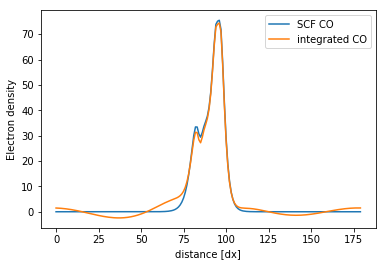

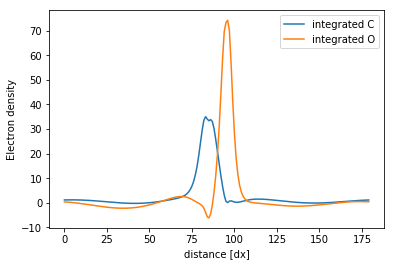

In [162]:
plt.ylabel('Electron density')
plt.xlabel('distance [dx]')

plt.plot(tf.sum(axis=1).sum(axis=1), label='SCF CO')
plt.plot((tr+tc+to).sum(axis=1).sum(axis=1), label='integrated CO')
plt.legend()

plt.show()
plt.ylabel('Electron density')
plt.xlabel('distance [dx]')
plt.plot((tc+tr/2).sum(axis=1).sum(axis=1), label='integrated C')
plt.plot((to+tr/2).sum(axis=1).sum(axis=1), label='integrated O')
plt.legend()

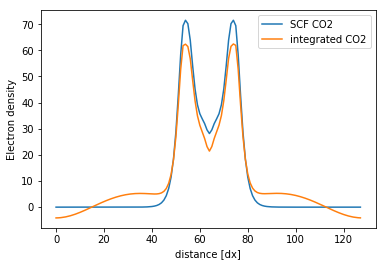

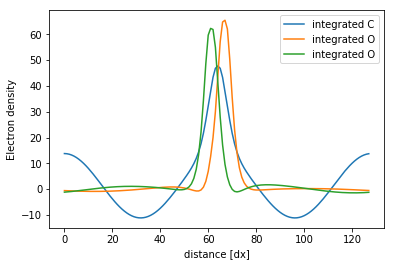

In [27]:
plt.ylabel('Electron density')
plt.xlabel('distance [dx]')

plt.plot(tf.sum(axis=0).sum(axis=1), label='SCF CO2')
plt.plot((tr+tc+to+ta).sum(axis=0).sum(axis=1), label='integrated CO2')
plt.legend()

plt.show()
plt.ylabel('Electron density')
plt.xlabel('distance [dx]')
plt.plot((tc+tr/3).sum(axis=1).sum(axis=1), label='integrated C')
plt.plot((to+tr/3).sum(axis=1).sum(axis=1), label='integrated O')
plt.plot((ta+tr/3).sum(axis=1).sum(axis=1), label='integrated O')
plt.legend()

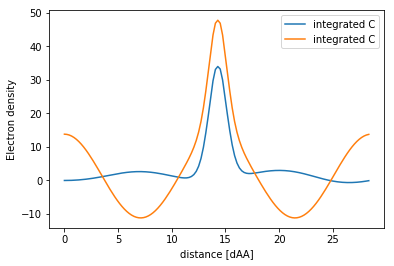

In [89]:
cube = CUBE('data-density/coo/box-15/lval-1.000000/DENSITY.cube')
plt.ylabel('Electron density')
plt.xlabel('distance [dAA]')
ys = (tc+tr/3).sum(axis=1).sum(axis=1)
xs = np.linspace(0, len(ys)*cube.X[0], len(ys))
plt.plot(xs, ys-yss, label='integrated C')
plt.plot(xs, ys, label='integrated C')
#plt.plot(xs, yss)
plt.legend()

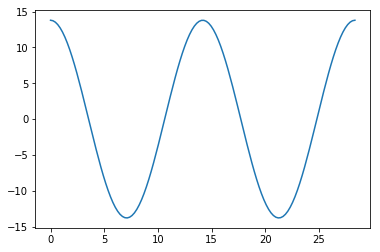

In [43]:
amplitude = ys[0]
periods = 2
yss = amplitude*np.sin(np.pi/2+2*np.pi*periods/len(ys)*np.linspace(0, len(ys), len(ys)))
plt.plot(xs, yss)


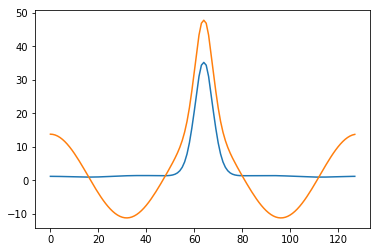

In [106]:
fd = np.fft.rfft(ys)
#fd[:3] = 0.
#fd[4:] = 0.
fd[2] = 300.
plt.plot(np.fft.irfft(fd))
plt.plot(ys)

(10, 20)

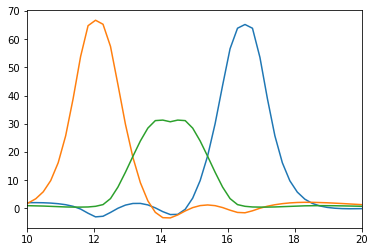

In [161]:
factor = [8, 8, 6]
combination = []
for qidx, q in enumerate((ta, to, tc)):
    ys = (q+tr * factor[qidx] / sum(factor)).sum(axis=0).sum(axis=1)
    fys = np.fft.rfft(ys)
    #fys[2] = np.sign(fys[2]) * (abs(fys[1])+abs(fys[3]))/2
    fys[2] = -(fys[1]+fys[3])/2
    ys2 = np.fft.irfft(fys)
    combination.append(ys2)
    #plt.plot(fys[:10], 'o-')
    plt.plot(xs, ys2)
plt.xlim(10, 20)

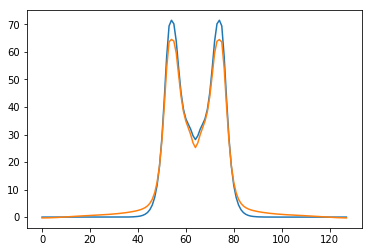

In [157]:
plt.plot((tf).sum(axis=0).sum(axis=1))
plt.plot(combination[0] + combination[1]+combination[2])

In [196]:
weightlookup = {'O': 8, 'C': 6, 'A': 8}
@functools.lru_cache(32)
def get_projected(basedir, axes, sites):
    cube = read_qs(basedir + '/lval-1.000000')
    actual = cube.data.sum(axis=axes[0]).sum(axis=axes[1])
    reference = read_qs(basedir + '/lval-0.000000').data.sum(axis=axes[0]).sum(axis=axes[1])
    
    partials = []
    derivatives = []
    for site in sites:
        tderivatives = []
        lvals = []
        ds = []
        for mval in '0.0 0.2 0.4 0.6 0.8 1.0'.split():
            tmp = get_deriv(basedir, mval, site)
            tderivatives.append(tmp.sum(axis=axes[0]).sum(axis=axes[1]))
            ds.append(tmp.ravel())
            lvals.append(float(mval))
        total = np.trapz(ds, lvals, axis=0)
        partials.append(total.reshape(tmp.shape).sum(axis=axes[0]).sum(axis=axes[1]))
    
    return cube.X[0], cube.Y[1], cube.Z[2], actual, partials, derivatives, reference, cube.atoms

FileNotFoundError: [Errno 2] No such file or directory: 'data-density/box-15//lval-0.000000-O-up/DENSITY.cube'

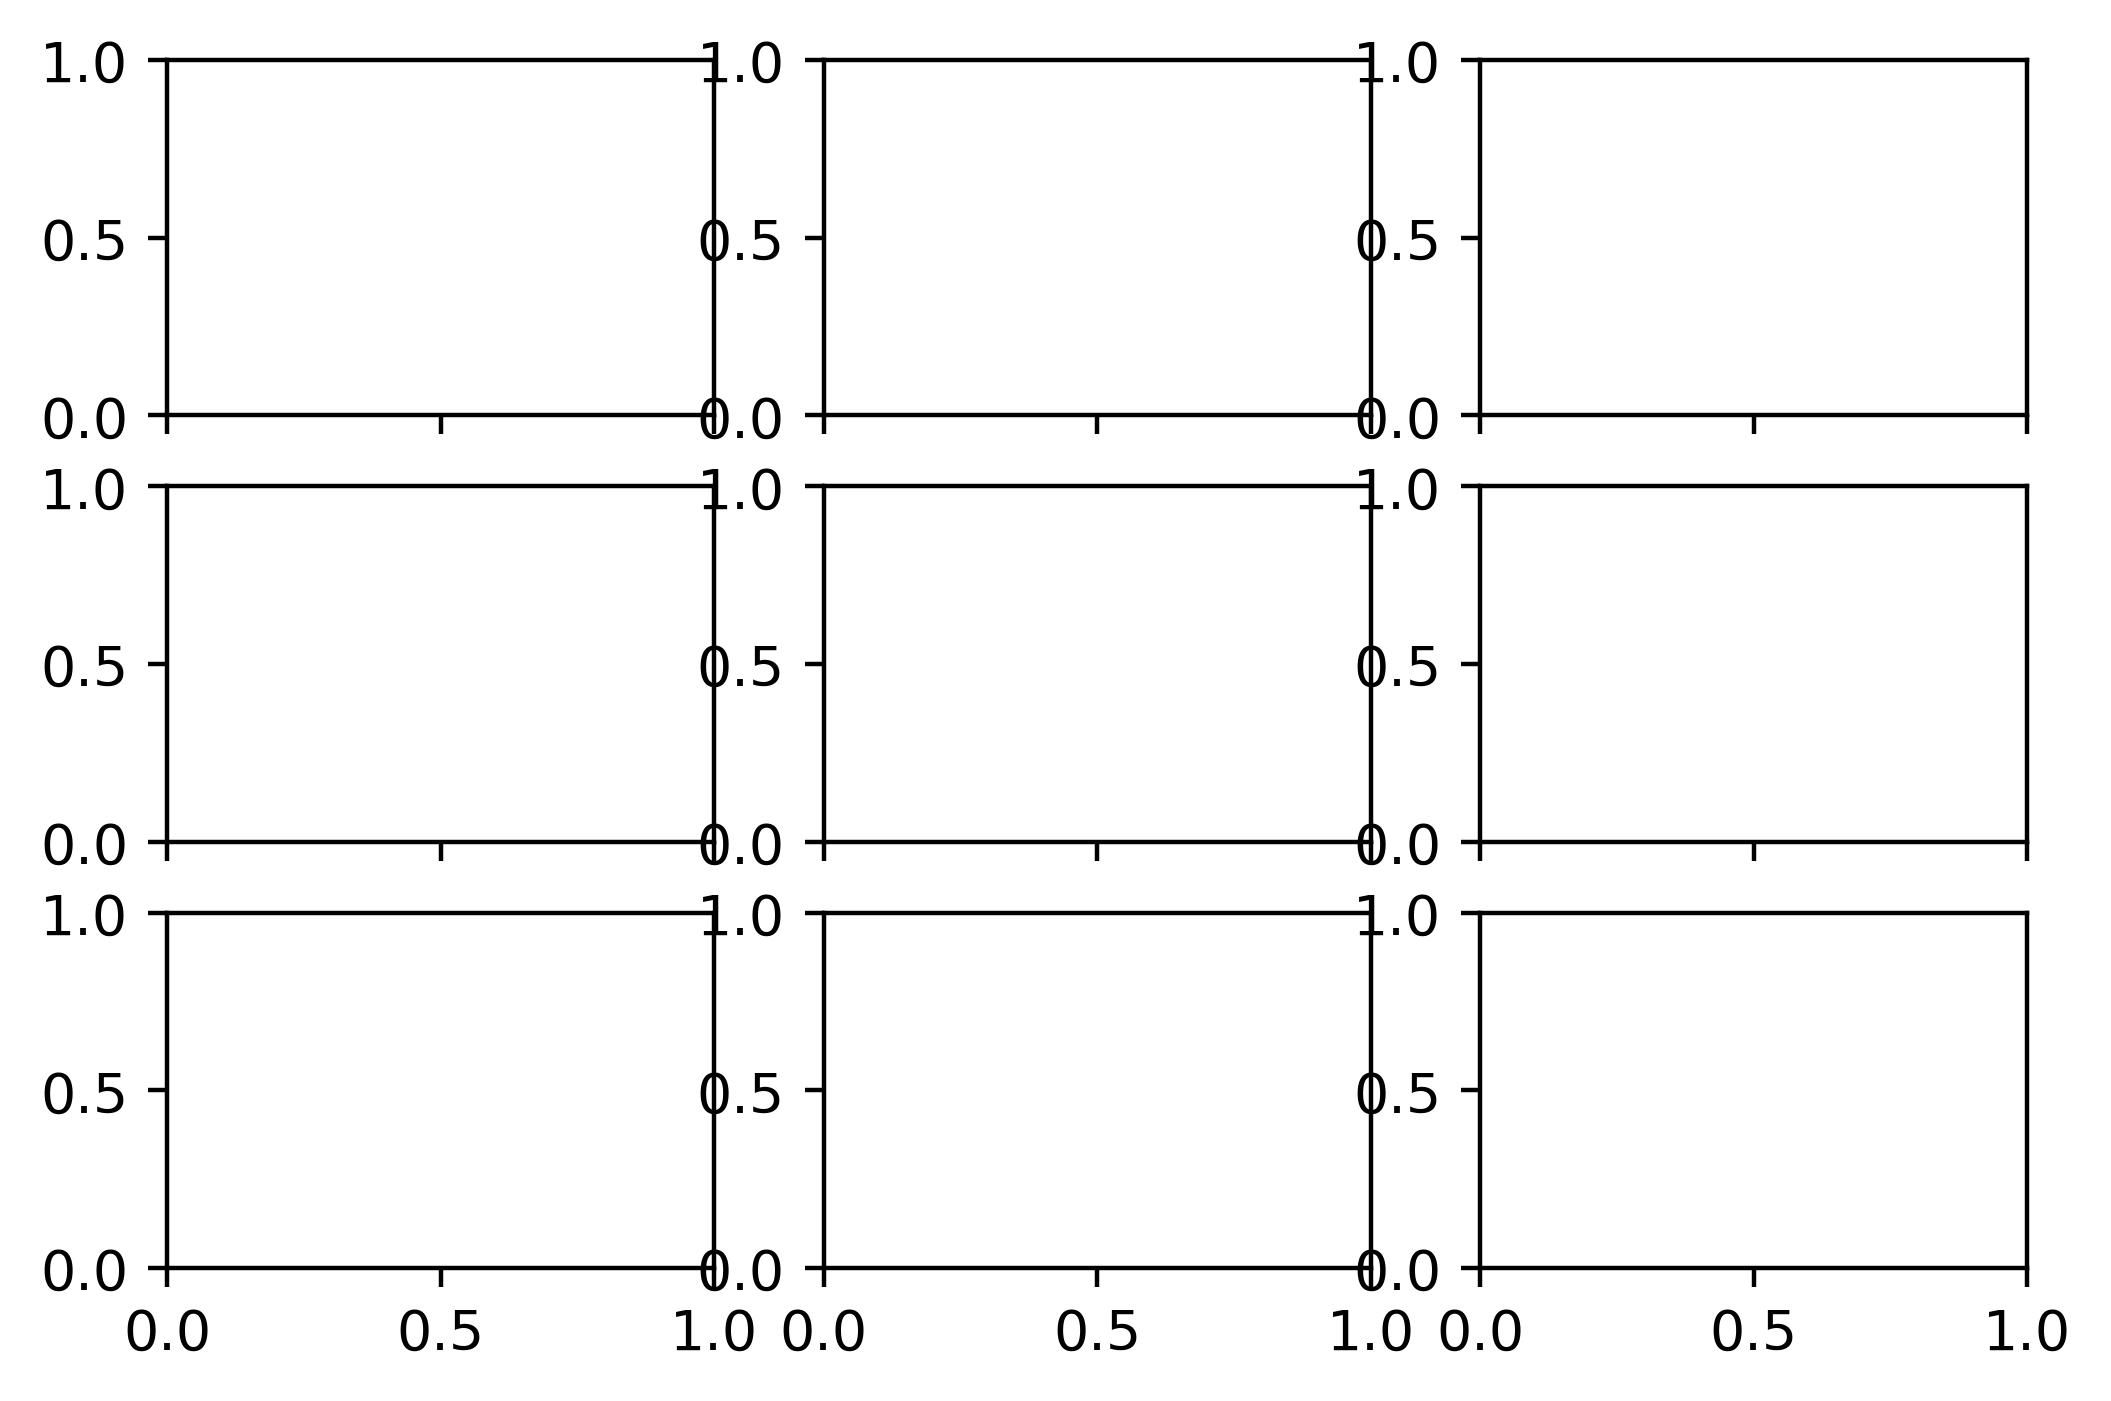

In [217]:
def density_figure():
    f, axs = plt.subplots(3, 3, dpi=400, sharex='col')
    
    def _plot_setup(basepath, projectionaxes, axes, sites):
        axtotal, axderiv, axdecomp = axes
        dx, dy, dz, actual, partials, derivatives, reference, atoms = get_projected(basepath, projectionaxes, sites)
        xs = np.linspace(0, len(actual)*dx, len(actual)+1)[:-1]
        
        # total plot
        axtotal.plot(xs, actual, label='CPMD')
        axtotal.plot(xs, partials[0]+ partials[1]+partials[2]+reference, label='APDFT')
        axtotal.legend()
        axtotal.set_xlim(10, 20)
        
        # contributions
        totalweight = float(sum([weightlookup[_] for _ in sites]))
        for sidx, site in enumerate(sites):
            axdecomp.plot(xs, partials[sidx] + weightlookup[site]/totalweight*reference, label=site)
        axdecomp.legend()
        
        # vertical lines
        pos = np.array(atoms)[:, 2].astype(float)
        for ax in axes:
            for p in pos:
                ax.axvline(p)
        
        
    #_plot_setup('data-density/coo/box-15/', (0, 1), axs[:, 0], 'OAC')
    _plot_setup('data-density/box-15/', (0, 1), axs[:, 1], 'OC')
    _plot_setup('data-density/CO-1.2/box-15/', (0, 1), axs[:, 2], 'OC')
    
density_figure()